# **Setting & Introduction**

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 "LGES_240704"로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES_240704

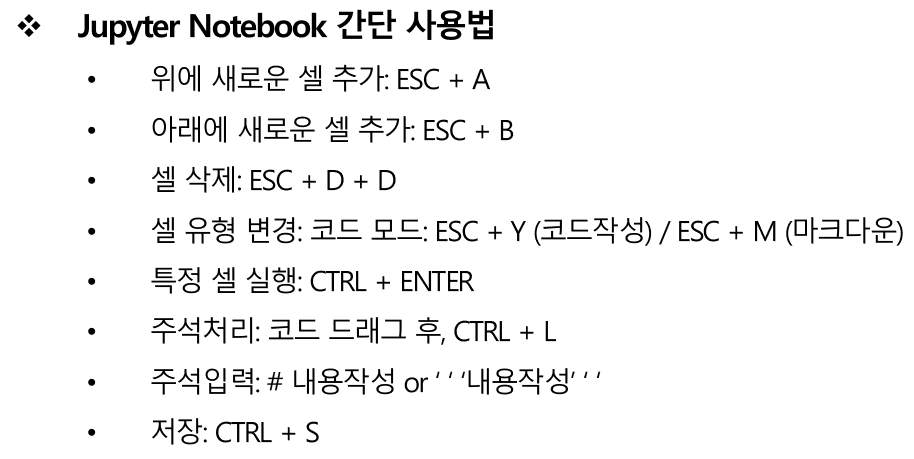

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG')

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - (2) Data Balancing (2) - Oversampling 

 - ***(3) XAI √***

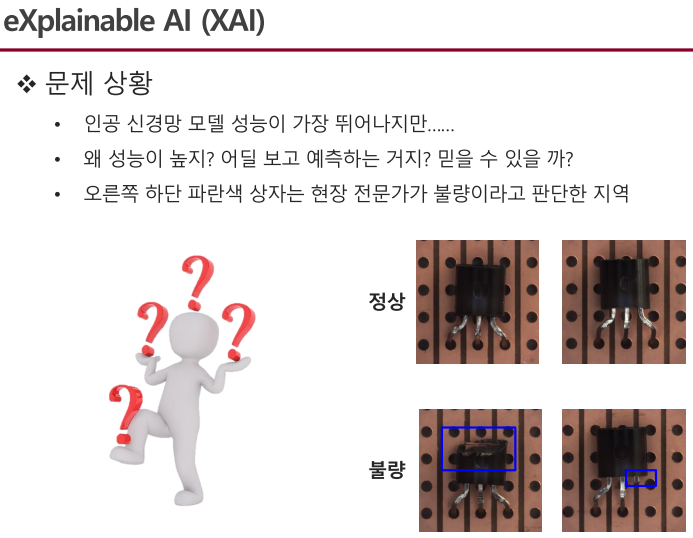

In [3]:
""" 설명 장표 불러오기 """
Image('image/9-XAI1.PNG')

## **[XAI - Tabular 목차]**

  - LIME

  - SHAP

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [3]:
""" 필요 패키지 설치 """
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 640.0 kB/s eta 0:00:01
     --------------- ---------------------- 112.6/275.7 kB 1.3 MB/s eta 0:00:01
     ------------------------------------ - 266.2/275.7 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.2/12.8 MB 5.4 MB/s eta 0:00:03
   - -------------------------------------- 0.4/12.8 MB 4.5 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/12.8 MB 4.5 MB/s eta 0:00:03
   -- ------------------------------------- 0.9/12.8 MB 5.1 MB/s eta 0:00:03
   --- ------------------------------------ 1.2/12.8 MB 4.9 MB/s eta 0:00:03
   ---- ----------------------------------- 1.5/12

In [4]:
""" 필요 패키지 설치 """
!pip install shap

   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ------ --------------------------------- 71.7/456.1 kB 2.0 MB/s eta 0:00:01
   ------------------------- -------------- 286.7/456.1 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 3.6 MB/s eta 0:00:00


In [4]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import itertools
import numpy as np
import pandas as pd


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


""" XAI 패키지 """
import shap
shap.initjs()
from shap import TreeExplainer
from lime.lime_tabular import LimeTabularExplainer


""" 시각화 패키지 """
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

c:\Users\korea\anaconda3\envs\py11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **0-2. 필요 함수 사전 정의**

In [5]:
""" (1) Confusion Matrix를 시각화하는 함수 """

def plot_confusion_matrix(confusion_matrix, classes):

    ### Confusion Matrix 시각화
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    ### X축 및 Y축 눈금에 Class 표시
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    ### Confusion Matrix 숫자 기입
    thresh = confusion_matrix.max() / 2. ### 폰트 색상 지정을 위한 Threshold
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), ### 숫자 작성
                 horizontalalignment="center", ### 숫자를 각 행렬 가운데 작성
                 color="white" if confusion_matrix[i, j] > thresh else "black") ### Threshold에 따라 글자 색상 다르게 지정

    ### X축 및 Y축 레이블 표기
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ### 이미지 크기 최적화 및 시각화
    plt.tight_layout()
    plt.show()

In [6]:
""" (2) 성능 평가 Metric을 산출하는 함수 """

"""
macro: Class 불균형을 고려한 성능지표
"""

def calculate_classification_metrics(true_labels, predicted_labels):
    
    ### 성능지표 산출
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    ### Log
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

## **1. 실습 데이터셋 확보**

 - 데이터: Adult 데이터 (사람의 개인정보를 기반으로 "수입>50k 여부" 이진 분류) - 32,561 X 15

 - 입력변수: Age, Workclass, fnlwgt, Education, ..., Country (15개)

 - 출력변수: Income

In [7]:
""" 데이터셋 불러오기"""

### 데이터셋 경로 지정
data_dir = 'data/adult.data' ### 로컬 사용 시

### 데이터셋 불러오기
df = pd.read_csv(data_dir, header=None)
df.columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
                "Marital Status","Occupation", "Relationship", "Race", "Sex",
                "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]

df

Age          Workclass  fnlwgt    Education  Education-Num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

            Marital Status          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
32556   Married-civ-spouse        Tech-support            Wife   White   
32557   Married-civ-spouse   Machine-op-inspct         Husband   White   
32558              Widowed        Adm-clerical       Unmarried   White   
32559        Never-married        Adm-clerical       Own-child   White   
32560   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  Capital Gain  Capital Loss  Hours per week         Country  \
0         Male          2174             0              40   United-States   
1         Male             0             0              13   United-States   
2         Male             0             0              40   United-States   
3         Male             0             0              40   United-States   
4       Female             0             0              40            Cuba   
...        ...           ...           ...             ...             ...   
32556   Female             0             0              38   United-States   
32557     Male             0             0              40   United-States   
32558   Female             0             0              40   United-States   
32559     Male             0             0              20   United-States   
32560   Female         15024             0              40   United-States   

       Income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32556   <=50K  
32557    >50K  
32558   <=50K  
32559   <=50K  
32560    >50K  

[32561 rows x 15 columns]

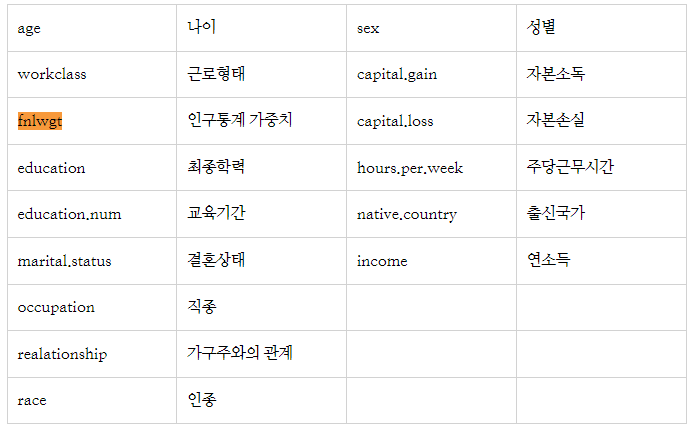

In [31]:
""" 설명 장표 불러오기 """
Image('image/9-XAI7.PNG')

In [8]:
""" 변수 타입 별 분류 """

col_categorical, col_numerical, col_target = [], [], []

for col, type_ in df.dtypes.to_dict().items():
    if col == 'Income': ### Y변수
        col_target.append(col)
    elif str(type_) == 'int64': ### X변수 & 수치형
        col_numerical.append(col)
    elif str(type_) == 'object': ### X변수 & 문자형
        col_categorical.append(col)
        
print(f"Categorical X변수: {len(col_categorical)}개 --> {col_categorical}")
print(f"Numercial X변수: {len(col_numerical)}개 --> {col_numerical}")
print(f"Y변수: {len(col_target)}개 --> {col_target}")

Categorical X변수: 8개 --> ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
Numercial X변수: 6개 --> ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
Y변수: 1개 --> ['Income']


In [9]:
""" Y변수 Label Encoding """

"""
Label Encoding: 문자형 변수를 수치형으로 Mapping
 - <=50K --> 0
 - >50K --> 1
"""

scaler_LB = LabelEncoder()
df[col_target[0]] = scaler_LB.fit_transform(df[col_target[0]])
df[col_target[0]]

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Income, Length: 32561, dtype: int32

In [10]:
""" X 내 범주형 변수 One-hot Encoding """

"""
One-hot Encoding: 문자형 변수들을 포함 여부에 따라서 구분
 - Country: Korea, Japan, China --> Country_Korea / Country_Japan / Country_China (각 변수 값은 True/False로 표기)
"""

cat_dummy = pd.get_dummies(df[col_categorical].astype(str))
cat_dummy

Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
0             False                   False                 False   
1             False                   False                 False   
2             False                   False                 False   
3             False                   False                 False   
4             False                   False                 False   
...             ...                     ...                   ...   
32556         False                   False                 False   
32557         False                   False                 False   
32558         False                   False                 False   
32559         False                   False                 False   
32560         False                   False                 False   

       Workclass_ Never-worked  Workclass_ Private  Workclass_ Self-emp-inc  \
0                        False               False                    False   
1                        False               False                    False   
2                        False                True                    False   
3                        False                True                    False   
4                        False                True                    False   
...                        ...                 ...                      ...   
32556                    False                True                    False   
32557                    False                True                    False   
32558                    False                True                    False   
32559                    False                True                    False   
32560                    False               False                     True   

       Workclass_ Self-emp-not-inc  Workclass_ State-gov  \
0                            False                  True   
1                             True                 False   
2                            False                 False   
3                            False                 False   
4                            False                 False   
...                            ...                   ...   
32556                        False                 False   
32557                        False                 False   
32558                        False                 False   
32559                        False                 False   
32560                        False                 False   

       Workclass_ Without-pay  Education_ 10th  ...  Country_ Portugal  \
0                       False            False  ...              False   
1                       False            False  ...              False   
2                       False            False  ...              False   
3                       False            False  ...              False   
4                       False            False  ...              False   
...                       ...              ...  ...                ...   
32556                   False            False  ...              False   
32557                   False            False  ...              False   
32558                   False            False  ...              False   
32559                   False            False  ...              False   
32560                   False            False  ...              False   

       Country_ Puerto-Rico  Country_ Scotland  Country_ South  \
0                     False              False           False   
1                     False              False           False   
2                     False              False           False   
3                     False              False           False   
4                     False              False           False   
...                     ...                ...             ...   
32556                 False              False           False   
32557                 False              False           False   
32558                 Fal

In [11]:
""" 모든 변수들을 결합 """
df = pd.merge(df[col_numerical+col_target], cat_dummy, how='left', left_index=True, right_index=True)
df

Age  fnlwgt  Education-Num  Capital Gain  Capital Loss  Hours per week  \
0       39   77516             13          2174             0              40   
1       50   83311             13             0             0              13   
2       38  215646              9             0             0              40   
3       53  234721              7             0             0              40   
4       28  338409             13             0             0              40   
...    ...     ...            ...           ...           ...             ...   
32556   27  257302             12             0             0              38   
32557   40  154374              9             0             0              40   
32558   58  151910              9             0             0              40   
32559   22  201490              9             0             0              20   
32560   52  287927              9         15024             0              40   

       Income  Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
0           0         False                   False                 False   
1           0         False                   False                 False   
2           0         False                   False                 False   
3           0         False                   False                 False   
4           0         False                   False                 False   
...       ...           ...                     ...                   ...   
32556       0         False                   False                 False   
32557       1         False                   False                 False   
32558       0         False                   False                 False   
32559       0         False                   False                 False   
32560       1         False                   False                 False   

       ...  Country_ Portugal  Country_ Puerto-Rico  Country_ Scotland  \
0      ...              False                 False              False   
1      ...              False                 False              False   
2      ...              False                 False              False   
3      ...              False                 False              False   
4      ...              False                 False              False   
...    ...                ...                   ...                ...   
32556  ...              False                 False              False   
32557  ...              False                 False              False   
32558  ...              False                 False              False   
32559  ...              False                 False              False   
32560  ...              False                 False              False   

       Country_ South  Country_ Taiwan  Country_ Thailand  \
0               False            False              False   
1               False            False              False   
2               False            False              False   
3               False            False              False   
4               False            False              False   
...               ...              ...                ...   
32556           False            False              False   
32557           False            False              False   
32558           False            False              False   
32559           False            False              False   
32560           False            False              False   

       Country_ Trinadad&Tobago  Country_ United-States  Country_ Vietnam  \
0                         False                    True             False   
1                         False                    True             False   
2                         False                    True             False   
3                         False                    True             False   
4                         False                   False             False   
...                      

In [12]:
""" Boolean Column을 Int로 변환 """
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)
df

Age  fnlwgt  Education-Num  Capital Gain  Capital Loss  Hours per week  \
0       39   77516             13          2174             0              40   
1       50   83311             13             0             0              13   
2       38  215646              9             0             0              40   
3       53  234721              7             0             0              40   
4       28  338409             13             0             0              40   
...    ...     ...            ...           ...           ...             ...   
32556   27  257302             12             0             0              38   
32557   40  154374              9             0             0              40   
32558   58  151910              9             0             0              40   
32559   22  201490              9             0             0              20   
32560   52  287927              9         15024             0              40   

       Income  Workclass_ ?  Workclass_ Federal-gov  Workclass_ Local-gov  \
0           0             0                       0                     0   
1           0             0                       0                     0   
2           0             0                       0                     0   
3           0             0                       0                     0   
4           0             0                       0                     0   
...       ...           ...                     ...                   ...   
32556       0             0                       0                     0   
32557       1             0                       0                     0   
32558       0             0                       0                     0   
32559       0             0                       0                     0   
32560       1             0                       0                     0   

       ...  Country_ Portugal  Country_ Puerto-Rico  Country_ Scotland  \
0      ...                  0                     0                  0   
1      ...                  0                     0                  0   
2      ...                  0                     0                  0   
3      ...                  0                     0                  0   
4      ...                  0                     0                  0   
...    ...                ...                   ...                ...   
32556  ...                  0                     0                  0   
32557  ...                  0                     0                  0   
32558  ...                  0                     0                  0   
32559  ...                  0                     0                  0   
32560  ...                  0                     0                  0   

       Country_ South  Country_ Taiwan  Country_ Thailand  \
0                   0                0                  0   
1                   0                0                  0   
2                   0                0                  0   
3                   0                0                  0   
4                   0                0                  0   
...               ...              ...                ...   
32556               0                0                  0   
32557               0                0                  0   
32558               0                0                  0   
32559               0                0                  0   
32560               0                0                  0   

       Country_ Trinadad&Tobago  Country_ United-States  Country_ Vietnam  \
0                             0                       1                 0   
1                             0                       1                 0   
2                             0                       1                 0   
3                             0                       1                 0   
4                             0                       0                 0   
...                      

In [13]:
""" 데이터 분할 """
col_categorical_onehot = cat_dummy.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(df[col_numerical+col_categorical_onehot],
                                                          df[col_target],
                                                          train_size=0.8,
                                                          random_state=2024)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 108), (6513, 108), (26048, 1), (6513, 1))

## **2. Base 모델 학습**

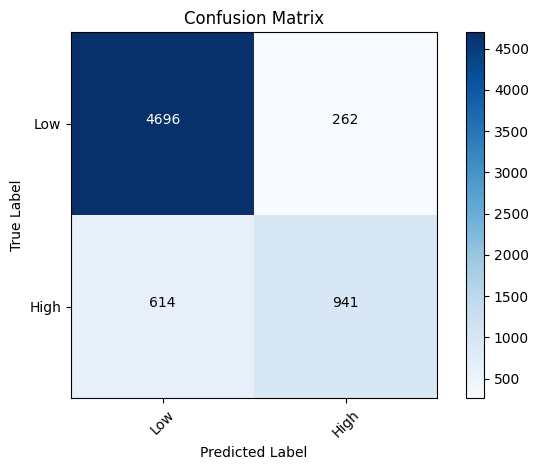

Accuracy : 0.8655
Precision : 0.8333
Recall : 0.7762
F1-score : 0.7985


In [14]:
""" GBM 모델링 """

### 모델 Train & Test
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=2024)
model_gb.fit(X_train, y_train)
y_pred_test = model_gb.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Low', 'High']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## **3. LIME**

 - https://lime-ml.readthedocs.io/en/latest

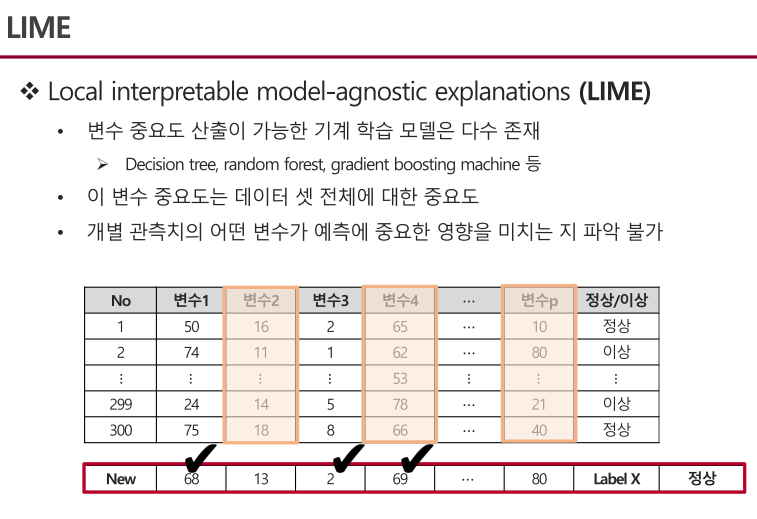

In [15]:
""" 설명 장표 불러오기 """
Image('image/9-XAI2.PNG')

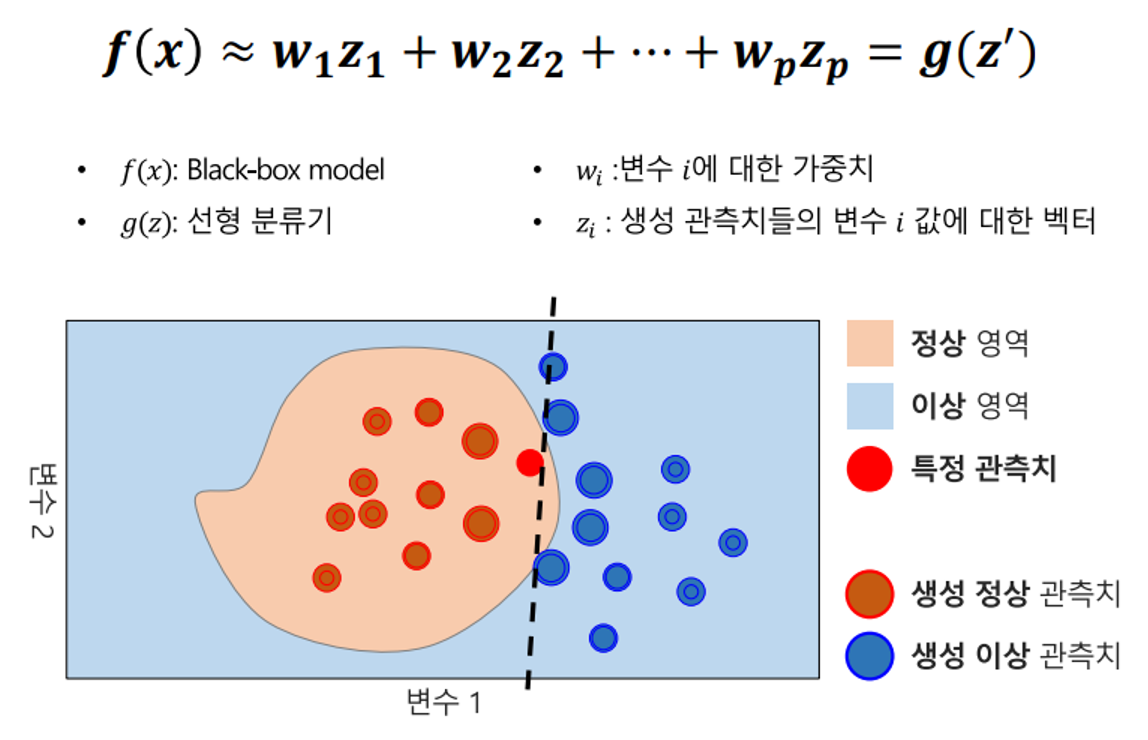

In [16]:
""" 설명 장표 불러오기 """
Image('image/9-XAI3.PNG')

In [17]:
""" LIME Explainer 정의 """
explainer = LimeTabularExplainer(training_data=X_train.values,
                                 mode='classification', ### Task
                                 feature_names=X_train.columns, ### X변수명
                                 categorical_features=col_categorical_onehot, ### X변수 중 Categorical 변수들
                                 class_names=['<=50K', '>50K'] ### Y의 Class
                                 )

In [22]:
""" Test 데이터의 0번째 관측치에 대한 결과 시각화 """
predict_fn = lambda x: model_gb.predict_proba(x)
exp = explainer.explain_instance(data_row=X_test.values[1], ### Test하고자 하는 Instance
                                 predict_fn=predict_fn, ### 기존에 학습한 모델
                                 num_features=13) ### 상위 몇개의 Feature 결과 확인할 것인지
exp.show_in_notebook()
print(y_test.iloc[1])

Income    0
Name: 12427, dtype: int32


In [21]:
""" Test 데이터의 0번째 관측치에 대한 결과 시각화 """
predict_fn = lambda x: model_gb.predict_proba(x)
exp = explainer.explain_instance(data_row=X_test.values[13], ### Test하고자 하는 Instance
                                 predict_fn=model_gb.predict_proba, ### 기존에 학습한 모델
                                 num_features=13) ### 상위 몇개의 Feature 결과 확인할 것인지
exp.show_in_notebook()
print(y_test.iloc[13])

Income    1
Name: 15278, dtype: int32


## **4. SHAP**

 - https://shap.readthedocs.io/en/latest/

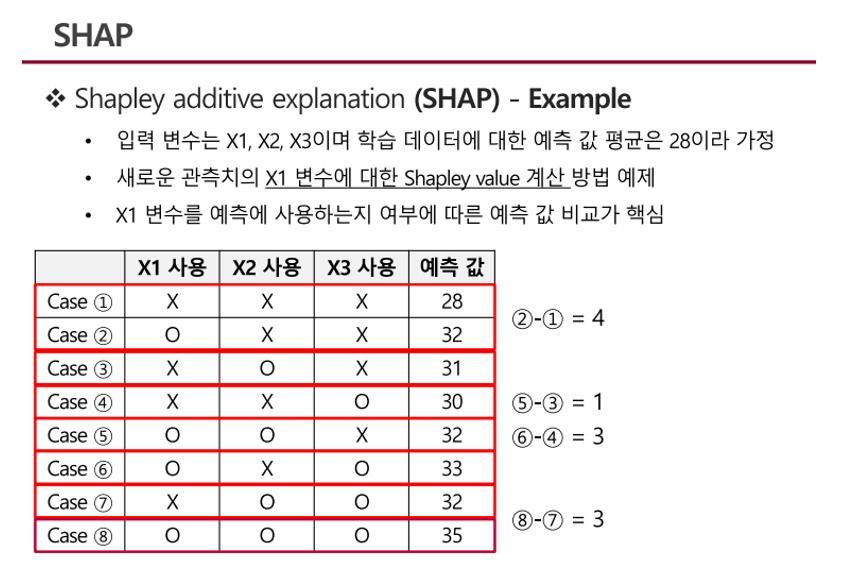

In [23]:
""" 설명 장표 불러오기 """
Image('image/9-XAI4.PNG')

In [24]:
""" SHAP Explainer 정의 후, SHAP Value 산출 """
explainer = TreeExplainer(model=model_gb,
                          data=X_train)
shap_values = explainer(X=X_test)

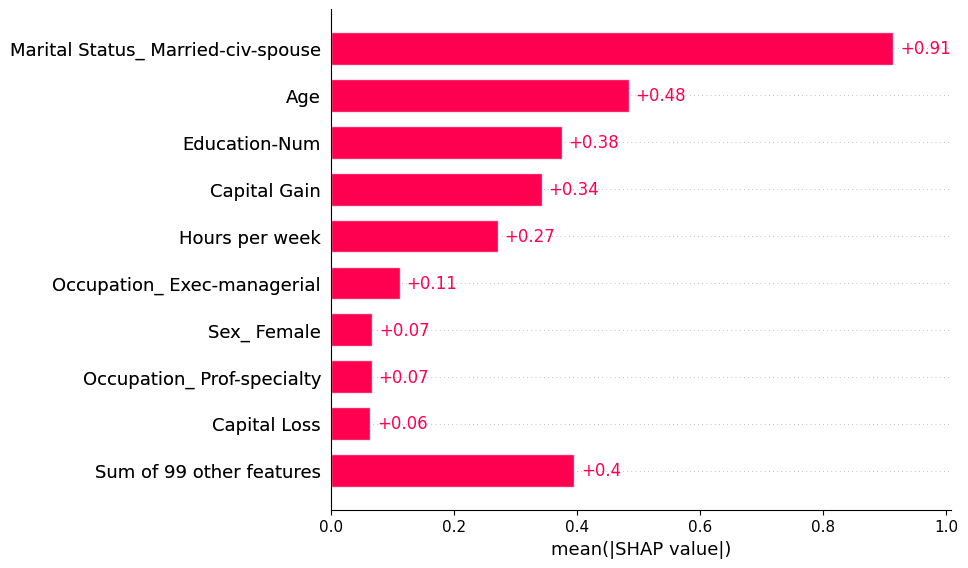

In [25]:
""" 전체 데이터셋 수준(Global) 변수 중요도 파악 """

"""
Shap value의 의미: 전체 데이터셋에 대한 평균 logit값(모델 출력값) 대비 shap value만큼 logit값에 영향을 준다.
EX) Marital Status_Married-civ-spouse(결혼한 상태면 1 아니면 0): 결혼에 대한 유무가 logit값을 평균적으로 0.91 변화시킨다.
"""

shap.plots.bar(shap_values=shap_values)

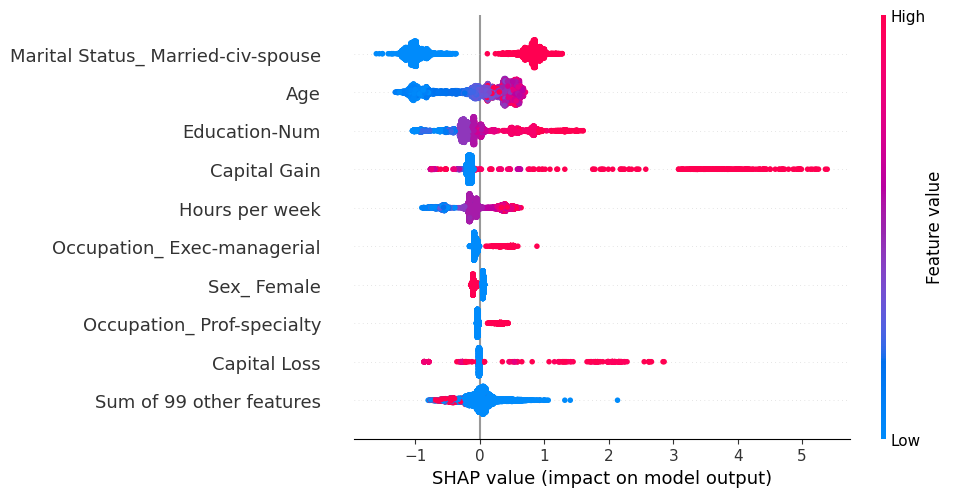

In [26]:
""" 전체 데이터셋 수준(Global) 상세 변수 중요도 파악 """

"""
Age: 나이가 많을수록 shap value가 클 확률이 높음 -> 나이가 많을수록 모델이 출력하는 logit값이 증가 -> 연봉을 50k 이상이라고 할 확률이 높음
"""

shap.plots.beeswarm(shap_values)

예측결과 : Class0


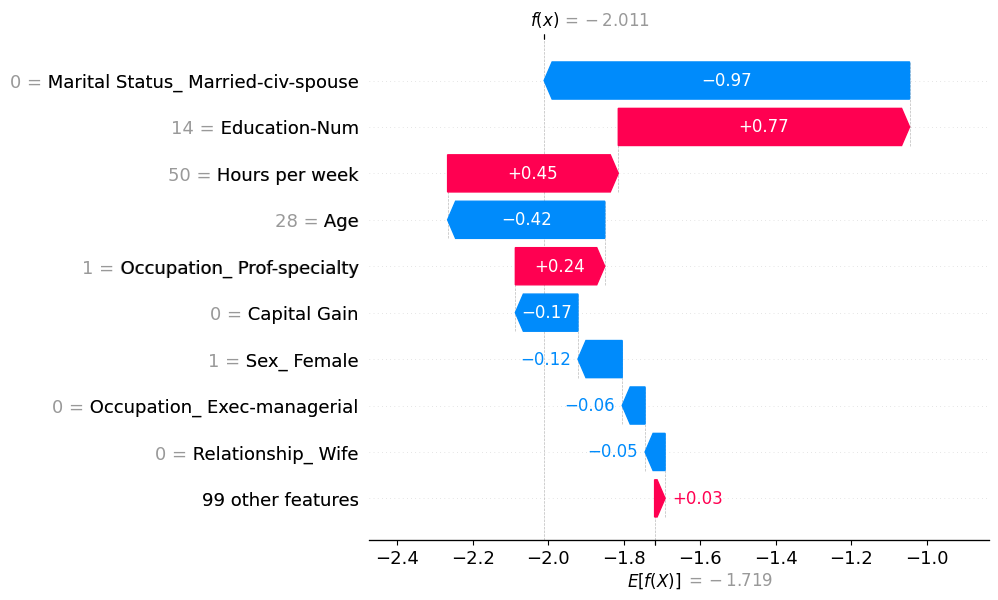

In [24]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
E(f(x)): 전체 Sample Logit값의 평균
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 1
print(f'예측결과 : Class{y_pred_test[sample_idx]}')
shap.plots.waterfall(shap_values[sample_idx])

In [32]:
""" Logit을 확률로 변환하여 확인 """
instance_logit = -2.011
average_logit = -1.719
instance_probability = 1 / (1 + np.exp(-instance_logit))
average_probability = 1 / (1 + np.exp(-average_logit))

print(f'Instance 확률: {round(instance_probability, 3)}')
print(f'평균 확률: {round(average_probability, 3)}')

Instance 확률: 0.118
평균 확률: 0.152


In [60]:
""" 실제 Class의 분포 확인 """
y_test['Income'].value_counts()

Income
0    4958
1    1555
Name: count, dtype: int64

예측결과 : Class1


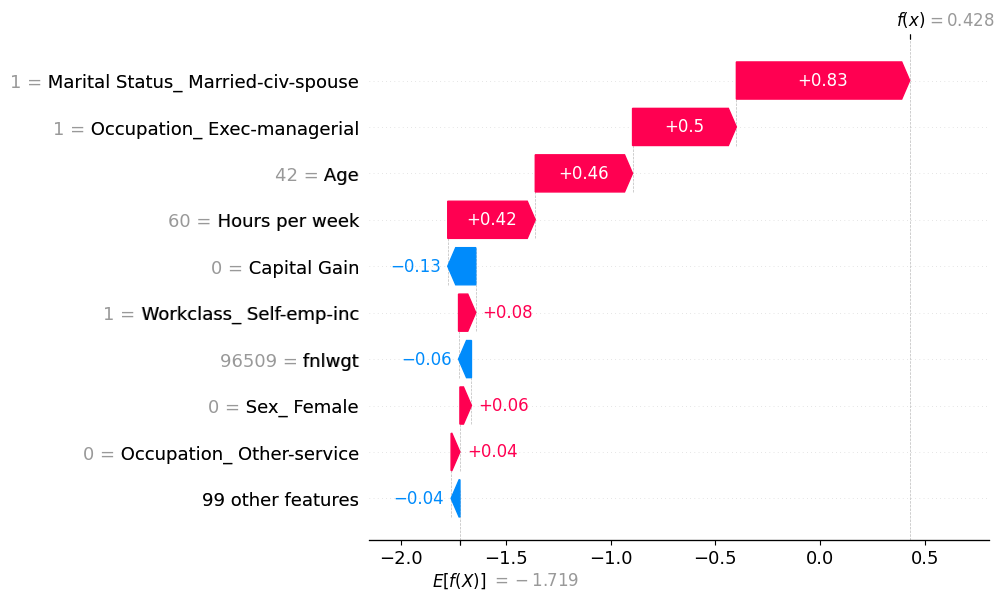

In [61]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
E(f(x)): 전체 Sample Logit값의 평균
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 3
print(f'예측결과 : Class{y_pred_test[sample_idx]}')
shap.plots.waterfall(shap_values[sample_idx])

In [62]:
""" Logit을 확률로 변환하여 확인 """
instance_logit = 0.428
average_logit = -1.719
instance_probability = 1 / (1 + np.exp(-instance_logit))
average_probability = 1 / (1 + np.exp(-average_logit))

print(f'Instance 확률: {round(instance_probability, 3)}')
print(f'평균 확률: {round(average_probability, 3)}')

Instance 확률: 0.605
평균 확률: 0.152


In [25]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
빨간색: Logit값을 높이는데 기여한 정도
파란색: Logit값을 낮추는데 기여한 정도
"""

sample_idx = 1
print(f'예측 레이블 : {y_pred_test[sample_idx]}')
shap.plots.force(explainer.expected_value, shap_values.values[sample_idx], features=X_test.iloc[sample_idx])

예측 레이블 : 0


In [26]:
""" 특정 관측치 수준(Local) 상세 변수 중요도 파악 """

"""
f(x): 현재 Sample의 Logit값
빨간색: Logit값을 높이는데 기여한 정도 
파란색: Logit값을 낮추는데 기여한 정도 
"""

sample_idx = 3
print(f'예측 레이블 : {y_pred_test[sample_idx]}')
shap.plots.force(explainer.expected_value, shap_values.values[sample_idx], features=X_test.iloc[sample_idx])

예측 레이블 : 1


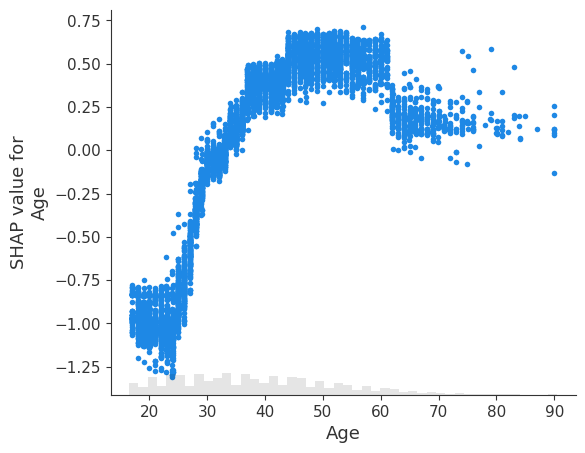

In [27]:
""" 특정 변수와 SHAP Value 간 상관관계 파악 """

"""
Age
 (1) 값이 작을수록 예측값이 작아지는데 큰 영향을 미침
 (2) 값이 클수록 예측값이 커지는데 큰 영향을 미침
   ex1) 2~30대: 낮은 예측값에 큰 기여
   ex2) 3~40대: Age가 큰 기여를 하지 못함
   ex3) 5~60대: 높은 예측값이 큰 기여
"""

shap.plots.scatter(shap_values[:, 'Age'])

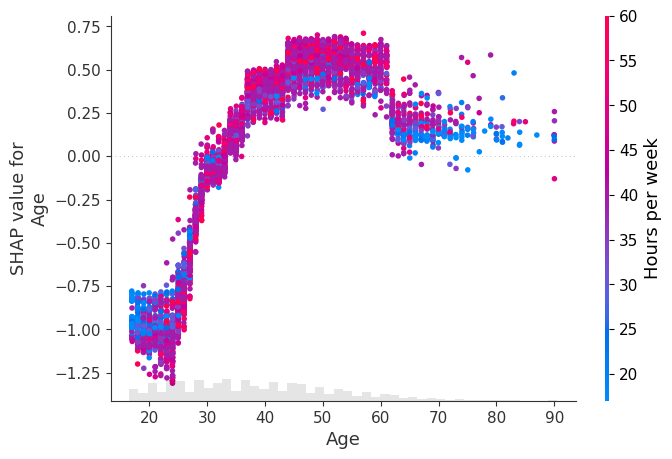

In [28]:
""" SHAP에 대한 변수간 교호작용 가능 파악 """

"""
(1) Age와 Hours per week가 모두 클 때, SHAP은 큰 경향을 보임 --> 높은 예측값에 크게 작용
(2) Age와 Hours per week가 모두 작을 때, SHAP은 낮은 경향을 보임 --> 낮은 예측값에 크게 작용
"""
shap.plots.scatter(shap_values[:, 'Age'], color=shap_values[:, 'Hours per week'])